# H1N1 and Seasonal Flu Vaccines Analysis

As the world struggles to vaccinate the global population against COVID-19, an understanding of how people’s backgrounds, opinions, and health behaviors are related to their personal vaccination patterns can provide guidance for future public health efforts. Your audience could be someone guiding those public health efforts.

This challenge: can you predict whether people got H1N1 and seasonal flu vaccines using data collected in the National 2009 H1N1 Flu Survey? This is a binary classification problem, but there are two potential targets: whether the survey respondent received the seasonal flu vaccine, or whether the respondent received the H1N1 flu vaccine. Please choose just one of these potential targets for your minimum viable project.

The goal is to predict how likely individuals are to receive their H1N1 and seasonal flu vaccines. 

Let's start with our imports, and then load in the data. I pulled the datasets from the competition website, linked here: https://www.drivendata.org/competitions/66/flu-shot-learning/data/

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style='white', palette='husl')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
! ls ../Data

submission_format.csv
test_set_features.csv
training_set_features.csv
training_set_labels.csv


According to the competition page, here's what each csv file is used for: 
1. Submission_format.csv: An example of how to format your submission for the competition. Don't need it for the analysis. 
2. Test_set_features.csv: These are the features for observations that you will use to generate the submission predictions after training a model. There are no labels for these samples. Don't need it for the analysis.
3. Training_set_features.csv: These are the input variables that your model will use to predict the probability that people received H1N1 flu and seasonal flu vaccines.
4. Training_set_labels.csv: These are the labels corresponding to the observations in the training features. There are two target variables: h1n1_vaccine and seasonal_vaccine. Both are binary variables, with 1 indicating that a person received the respective flu vaccine and 0 indicating that a person did not receive the respective flu vaccine. Note that this is what is known as a "multilabel" modeling task.

Based on this knowledge, we won't load the submission_format.csv file or the test_set_features.csv file as we don't need them for the analysis (if there's time, could potentially use them as an additional test set after the train-test split). After loading and reviewing, both files containt the "respondent_id" column, so let's make this our index for easy lookups. 

In [3]:
# load in the training set features file, set the index column equal to respondent id.
training_features = pd.read_csv('../Data/training_set_features.csv', index_col='respondent_id')
training_features.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [4]:
# load in the training set labels file, set the index column equal to respondent id.
training_labels = pd.read_csv('../Data/training_set_labels.csv', index_col='respondent_id')
training_labels.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


Let's look at the shape of each file to see if they're the same size.

In [5]:
training_features.shape

(26707, 35)

In [6]:
training_labels.shape

(26707, 2)

Both are the same shape, so that's good.

### Target Analysis

There are 2 possible targets in this dataset, the H1N1 vaccine and the seasonal vaccine columns. We only need to pick one to work with, so let's look at them and see how they are distributed. 

In [7]:
training_labels.head(2)

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1


In [8]:
# everything is an integer
training_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   h1n1_vaccine      26707 non-null  int64
 1   seasonal_vaccine  26707 non-null  int64
dtypes: int64(2)
memory usage: 625.9 KB


In [9]:
# no null values
training_labels.isna().sum()

h1n1_vaccine        0
seasonal_vaccine    0
dtype: int64

In [10]:
# looks like seasonal vaccine has a higher mean and std
# as promised, binary columns - 0 for have not gotten the vaccine, 1 for have gotten the vaccine.
training_labels.describe()

,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26707.000000
mean,0.212454,0.465608
std,0.409052,0.498825
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,1.000000
max,1.000000,1.000000


In [11]:
# is there a correlation between the 2 targets?
training_labels['h1n1_vaccine'].corr(training_labels['seasonal_vaccine'])

# slight positive correlation

0.37714265306144706

Let's visualize the distribution. 

In [12]:
# This is imbalanced - 79% of people have not gotten the h1h1 vaccine, and 21% have. 
training_labels['h1n1_vaccine'].value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

In [13]:
# much more balanced - 53% have not gotten the seasonal vacc, but 47% have.
training_labels['seasonal_vaccine'].value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

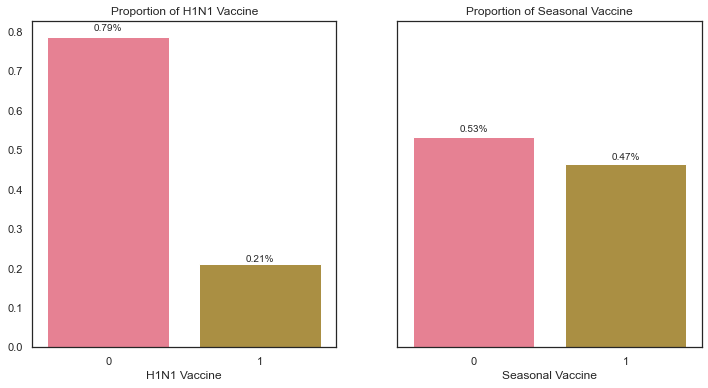

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,6))

# barplot for the h1n1 vacc
sns.barplot(x=training_labels['h1n1_vaccine'].value_counts(normalize=True).index, 
            y=list(training_labels['h1n1_vaccine'].value_counts(normalize=True)),
            data=training_labels, 
           ax=ax[0])
ax[0].set_xlabel('H1N1 Vaccine')
ax[0].set_title('Proportion of H1N1 Vaccine')

# add the percents on top of the bar plots
for p in ax[0].patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax[0].annotate(f'{height/100:.2%}', (x + width/2, y + height*1.02), ha='center')


# barplot for the seasonal vacc
sns.barplot(x=training_labels['seasonal_vaccine'].value_counts(normalize=True).index,
            y=list(training_labels['seasonal_vaccine'].value_counts(normalize=True)),
            data=training_labels, 
           ax=ax[1])
ax[1].set_xlabel('Seasonal Vaccine')
ax[1].set_title('Proportion of Seasonal Vaccine')

# add the percents on top of the bar plots
for p in ax[1].patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax[1].annotate(f'{height/100:.2%}', (x + width/2, y + height*1.02), ha='center');

The H1N1 vaccine is imbalanced - 79% of people have not gotten the vaccine, and only 21% have. The seasonal vaccine on the other hand is much more balanced. 53% of people have not gotten the vaccine, while 47% have. 

It might be easier to use the seasonal vaccine as the target, but it seems more fun to use use H1N1 as the target so I can practice using SMOTE later on.

So let's have H1N1 be our target. 

### Feature Analysis

Now that we have a target, let's explore the feature columns. 

From the problem description of the competition (https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/), many columns are binary, many are rated from 0-3 or 0-5.

In [15]:
training_features.head(2)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe


In [16]:
training_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

Everything is either a float or an object. Seems like there are null values in some of the binary columns, I'm curious if they're actually missing or just being mistranslated. Let's spot check a few.

In [17]:
# how many nulls does each column have?
training_features.isna().sum().sort_values(ascending=False)

employment_occupation          13470
employment_industry            13330
health_insurance               12274
income_poverty                  4423
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
rent_or_own                     2042
employment_status               1463
marital_status                  1408
education                       1407
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
opinion_seas_sick_from_vacc      537
opinion_seas_risk                514
opinion_seas_vacc_effective      462
opinion_h1n1_sick_from_vacc      395
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
household_adults                 249
household_children               249
behavioral_avoidance             208
behavioral_touch_face            128
h1n1_knowledge                   116
h1n1_concern                      92
behavioral_large_gatherings       87
behavioral_outside_home           82
b

In [18]:
# spot check h1n1_knowledge
training_features['h1n1_knowledge'].value_counts()

1.0    14598
2.0     9487
0.0     2506
Name: h1n1_knowledge, dtype: int64

In [19]:
training_features[training_features['h1n1_knowledge'].isna()].head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
136,3.0,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,oxchjgsf,Non-MSA,0.0,0.0,atmlpfrs,xqwwgdyp
405,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Unemployed,lzgpxyit,Non-MSA,1.0,0.0,NaN,NaN
958,1.0,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,qufhixun,"MSA, Principle City",1.0,0.0,NaN,NaN
1026,3.0,NaN,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,lzgpxyit,"MSA, Not Principle City",1.0,0.0,nduyfdeo,pvmttkik
1122,2.0,NaN,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Principle City",1.0,2.0,wxleyezf,emcorrxb


In [20]:
# and spot check behavioral_avoidance
training_features['behavioral_avoidance'].value_counts()

1.0    19228
0.0     7271
Name: behavioral_avoidance, dtype: int64

In [21]:
training_features[training_features['behavioral_avoidance'].isna()]['h1n1_concern'].value_counts()

2.0    65
1.0    58
0.0    48
3.0    31
Name: h1n1_concern, dtype: int64

It kind of seems like it depends on the column. For h1n1_knowledge, it seems like N/A could just mean 0 (not at all concerned according to the data dictionary). But things like behavioral_avoidance might be a little trickier as it seems there is no pattern to which concern level it relates to.

Let's look at the relationship between the target and some of the feature columns. Let's make it a little easier and just combine the dataframes for this.

In [22]:
features_labels = training_features.join(training_labels)
features_labels.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [23]:
features_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

There are a lot of interesting columns to compare against H1N1 vaccinations. Let's start looking at a few. 

First, let's see how everything is correlated to h1n1_vaccine. Let's look at the absolute value so if there are any strong negative correlations, they are at the top of the list instead of the bottom.

In [24]:
h1n1_corrs = abs(features_labels.corr()['h1n1_vaccine']).sort_values(ascending=False)
h1n1_corrs_df = pd.DataFrame(h1n1_corrs)
h1n1_corrs_df

,h1n1_vaccine
h1n1_vaccine,1.000000
doctor_recc_h1n1,0.393890
seasonal_vaccine,0.377143
opinion_h1n1_risk,0.323265
opinion_h1n1_vacc_effective,0.269347
opinion_seas_risk,0.258571
doctor_recc_seasonal,0.209864
opinion_seas_vacc_effective,0.179272
health_worker,0.169768
h1n1_concern,0.121929


Doctor rec and h1n1 vaccine seem to have a the strongest positive correlation, but only around 39%. Opinion of the risk/vaccine effectiveness seem to also have slight positive correlations. 

Let's visualize them.

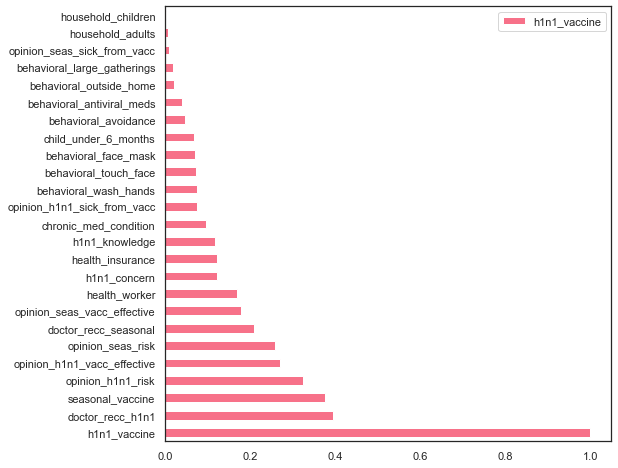

In [25]:
h1n1_corrs_df.plot(kind='barh', figsize=(8,8));

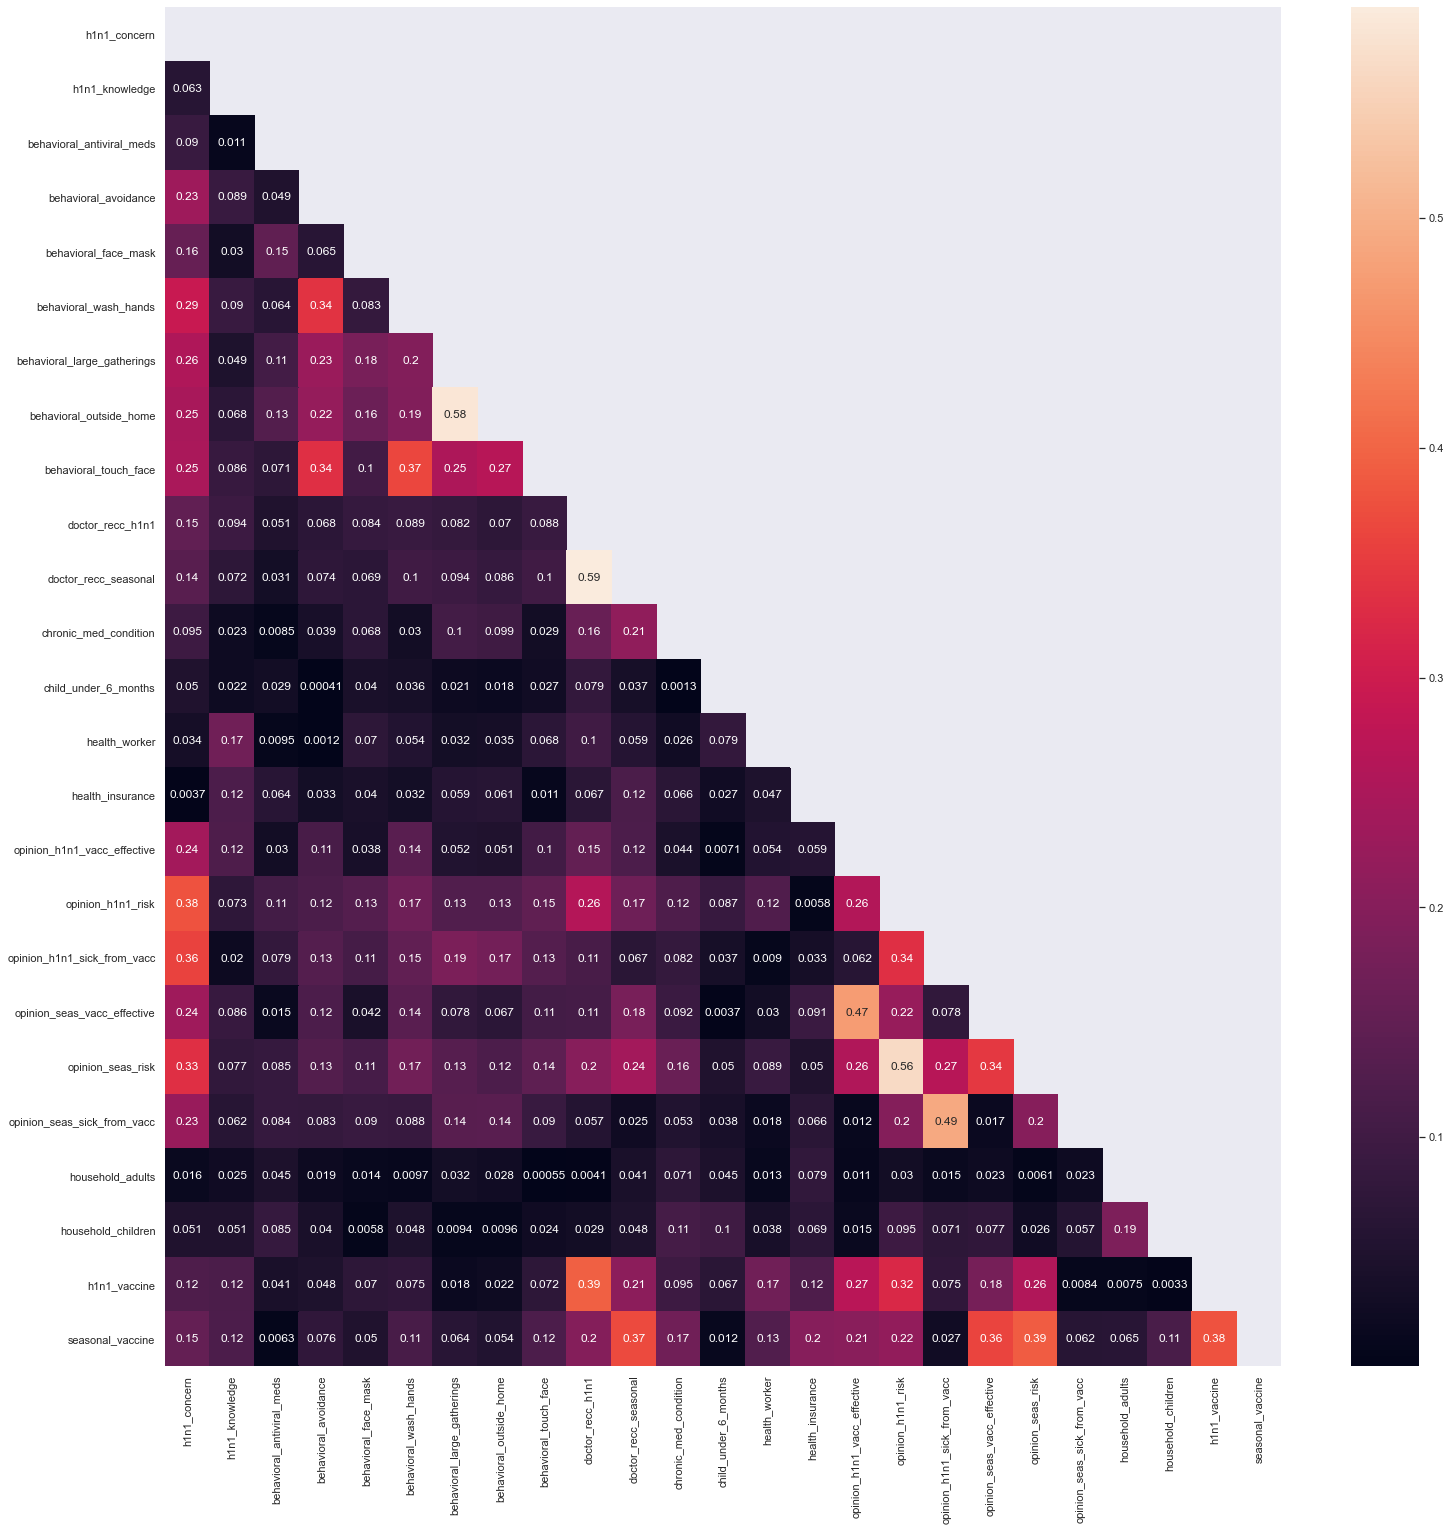

In [26]:
sns.set(rc={'figure.figsize':(25, 25)})

mask = np.triu(np.ones_like(features_labels.corr()))

sns.heatmap(abs(features_labels.corr()), mask=mask, annot=True);

This doesn't really give us any new information. Let's take the top 6 or so (choosing 6 so I can plot it nicely) and then look at the distribution. I'm going to also exclude H1N1 vaccine as it's perfectly correlated with itself, and we have the distribution in an earlier chart. 

In [27]:
# let's also drop seasonal as we want to look at h1n1
# and the doctor_recc_seasonal as that relates just to seasonal
top_6_corr_cols = list(h1n1_corrs_df.drop(index=['h1n1_vaccine', 'seasonal_vaccine', 'doctor_recc_seasonal']).head(6).index)
top_6_corr_cols

['doctor_recc_h1n1',
 'opinion_h1n1_risk',
 'opinion_h1n1_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_vacc_effective',
 'health_worker']

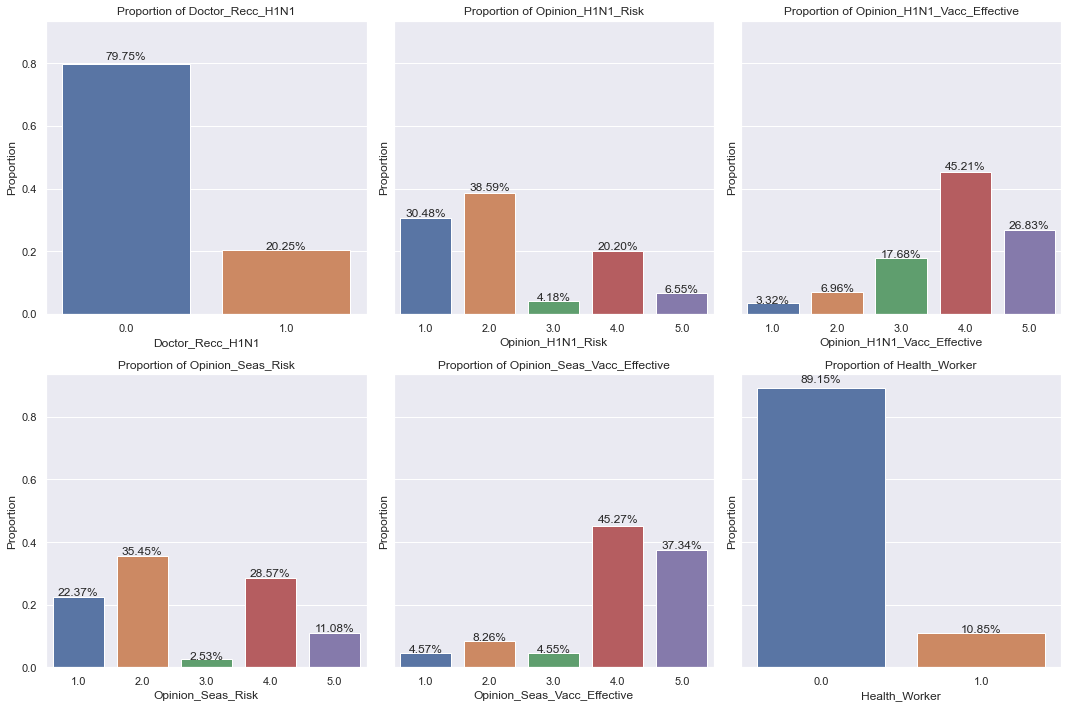

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(15, 10))

columns = top_6_corr_cols

for index, column in enumerate(columns):
    row = index // 3
    col = index % 3
    
    # the missing values were causing nothing to pop up.
    # for the purposes of this visualization, let's fill in missing values with the mode value.
    features_labels[column].fillna(features_labels[column].mode().iloc[0], inplace=True)
    
    x = features_labels[column].value_counts(normalize=True).index
    y = features_labels[column].value_counts(normalize=True)
    
    sns.barplot(x=x, y=y, ax=axes[row, col])
    
    axes[row, col].set_xlabel(f"{column.title()}")
    axes[row, col].set_ylabel(f"Proportion")
    axes[row, col].set_title(f"Proportion of {column.title()}")
    
    for p in axes[row, col].patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        axes[row, col].annotate(f'{height*100:.2f}%', (x + width/2, y + height*1.02), ha='center')

plt.tight_layout();

Here, opinions on the risk/effectiveness of the vaccine might have an impact on whether someone gets the vaccination. 

Surprisingly, it looks like most health care workers did not get the vaccine. 

Let's look closer at the opinions (risk and effectiveness).

In [29]:
corr_plot = features_labels[['h1n1_vaccine','opinion_h1n1_risk', 'opinion_h1n1_vacc_effective']].corr()
corr_plot

,h1n1_vaccine,opinion_h1n1_risk,opinion_h1n1_vacc_effective
h1n1_vaccine,1.000000,0.320580,0.267352
opinion_h1n1_risk,0.320580,1.000000,0.259813
opinion_h1n1_vacc_effective,0.267352,0.259813,1.000000


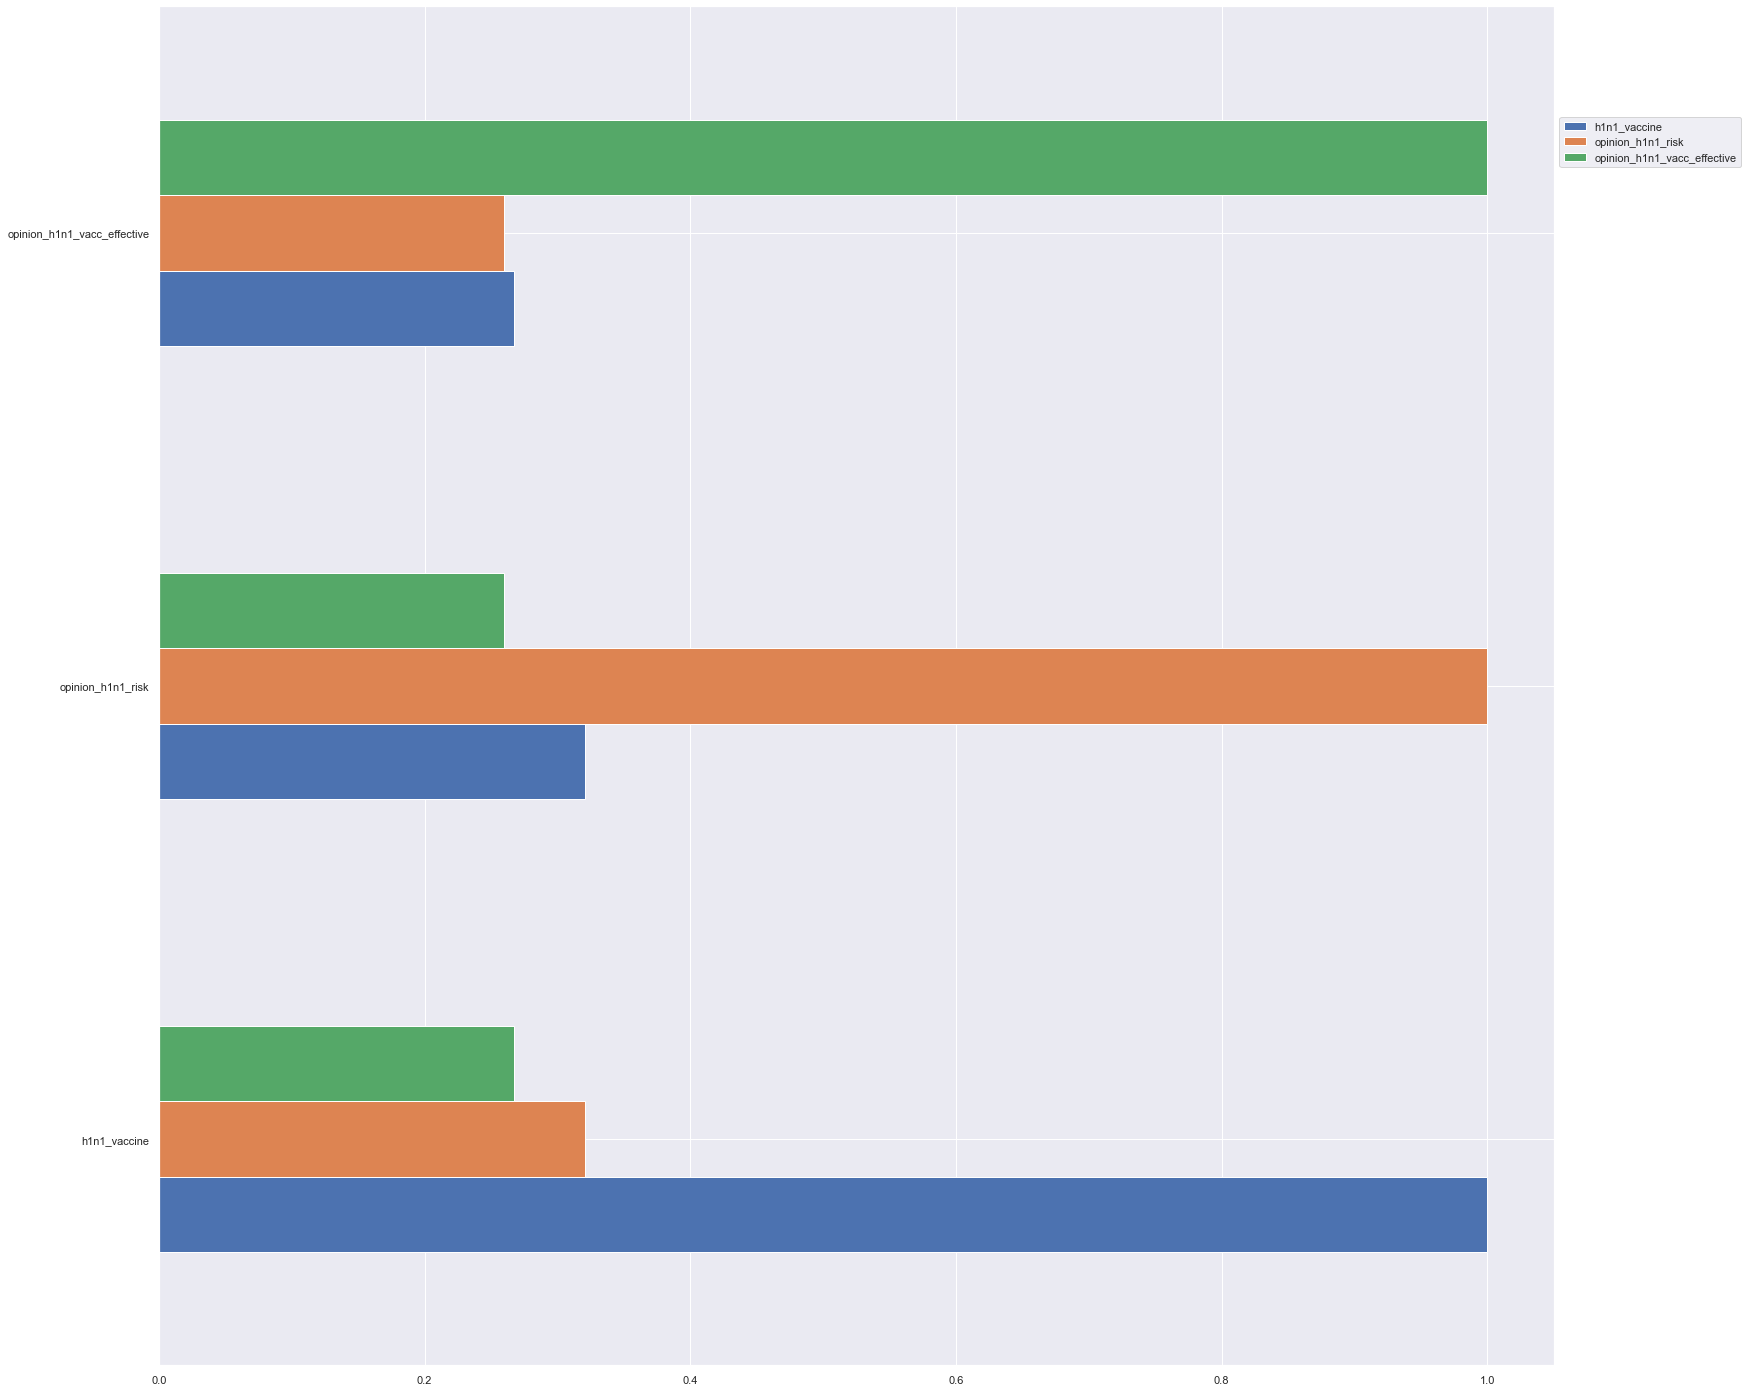

In [30]:
corr_plot.plot(kind='barh').legend(loc='center left', bbox_to_anchor=(1, 0.9));

So here, we can see that for vaccinate effectiveness, both h1n1 vaccine and opinion on the risk are similarly correlated. For opinion on the risk, there is a slightly higher correlation with h1n1 vaccine. For h1n1 vaccine, there is a slightly higher correlation with opinion on risk. 

So it seems that opinion on the risk plays a slightly bigger role in whether someone got vaccinated or not than the effectiveness of the vaccine. 

Let's look at some of the categorical columns. 

In [31]:
objects = features_labels.select_dtypes('object')
object_cols = list(objects.columns)
print(len(object_cols))
print(object_cols)

12
['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']


Let's look at the counts of each age group and whether they got the vaccine or not.

In [32]:
features_labels.groupby('age_group')[['h1n1_vaccine']].count().sort_values(by='h1n1_vaccine', ascending=False)

,h1n1_vaccine
age_group,
65+ Years,6843
55 - 64 Years,5563
45 - 54 Years,5238
18 - 34 Years,5215
35 - 44 Years,3848


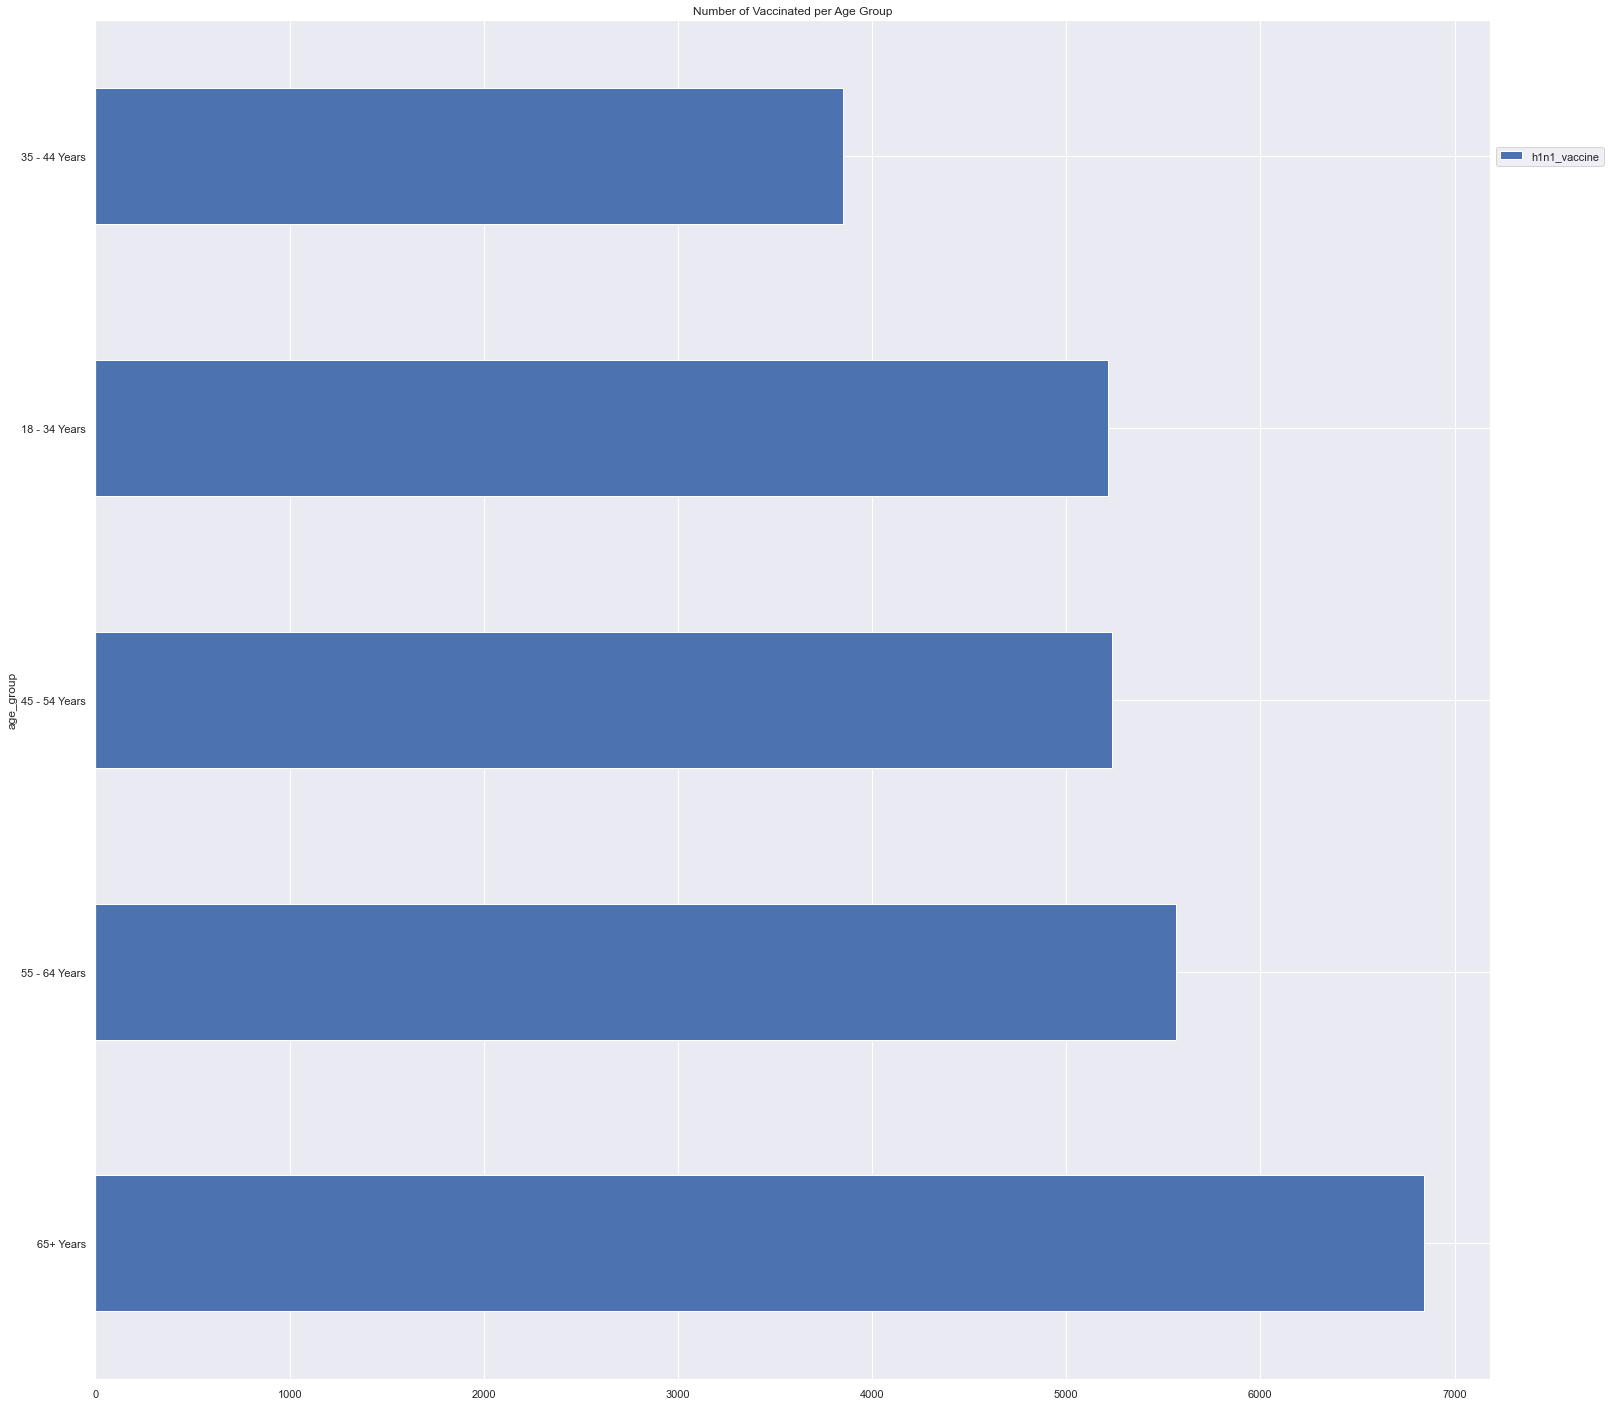

In [33]:
age_plot = features_labels.groupby('age_group')[['h1n1_vaccine']].count().sort_values(by='h1n1_vaccine', 
                                                                                      ascending=False).plot(kind='barh')
age_plot.legend(loc='center left', bbox_to_anchor=(1, 0.9))
age_plot.set_title('Number of Vaccinated per Age Group');

I think this is taking the entire count, not split up by vaccinated or not, so let's split by vaccinated or not, and then groupby that way and see if it looks better. We can plot the two grouped dataframes on the same plot and compare that way.

In [34]:
not_vaccinated = features_labels.loc[features_labels['h1n1_vaccine'] == 0]
vaccinated = features_labels.loc[features_labels['h1n1_vaccine'] == 1]

In [35]:
not_vacc_age_grouped = not_vaccinated.groupby('age_group')[['h1n1_vaccine']].count().sort_values(by='h1n1_vaccine', 
                                                                                             ascending=False)
not_vacc_age_grouped

,h1n1_vaccine
age_group,
65+ Years,5292
18 - 34 Years,4224
45 - 54 Years,4218
55 - 64 Years,4212
35 - 44 Years,3087


In [36]:
vacc_age_grouped = vaccinated.groupby('age_group')[['h1n1_vaccine']].count().sort_values(by='h1n1_vaccine', ascending=False)
vacc_age_grouped

,h1n1_vaccine
age_group,
65+ Years,1551
55 - 64 Years,1351
45 - 54 Years,1020
18 - 34 Years,991
35 - 44 Years,761


In [37]:
age_groups = vacc_age_grouped.index

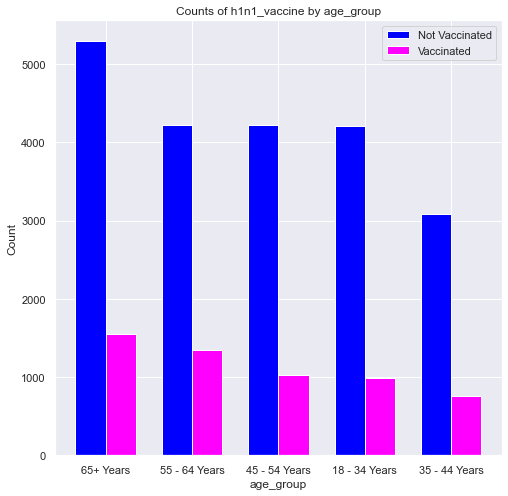

In [38]:
fig, ax = plt.subplots(figsize=(8,8))
bar_width = 0.35

index = range(len(not_vacc_age_grouped))
x_not_vaccinated = [i - bar_width/2 for i in index]
x_vaccinated = [i + bar_width/2 for i in index]


ax.bar(x=x_not_vaccinated, height=not_vacc_age_grouped['h1n1_vaccine'].values, 
       label='Not Vaccinated', width=bar_width, color='blue')

ax.bar(x=x_vaccinated, height=vacc_age_grouped['h1n1_vaccine'].values, 
       label='Vaccinated', width=bar_width, color='magenta')

ax.set_xlabel('age_group')
ax.set_ylabel('Count')
ax.set_title('Counts of h1n1_vaccine by age_group')
ax.set_xticks(index)
ax.set_xticklabels(age_groups)
ax.legend()
plt.show();

Unsurpisingly, the most vaccinated groups are the oldest and youngest people. Although there are significantly many more unvaccinated than vaccinated. I'm interested in seeing this plot for all of the categoricals. Let's try it. 

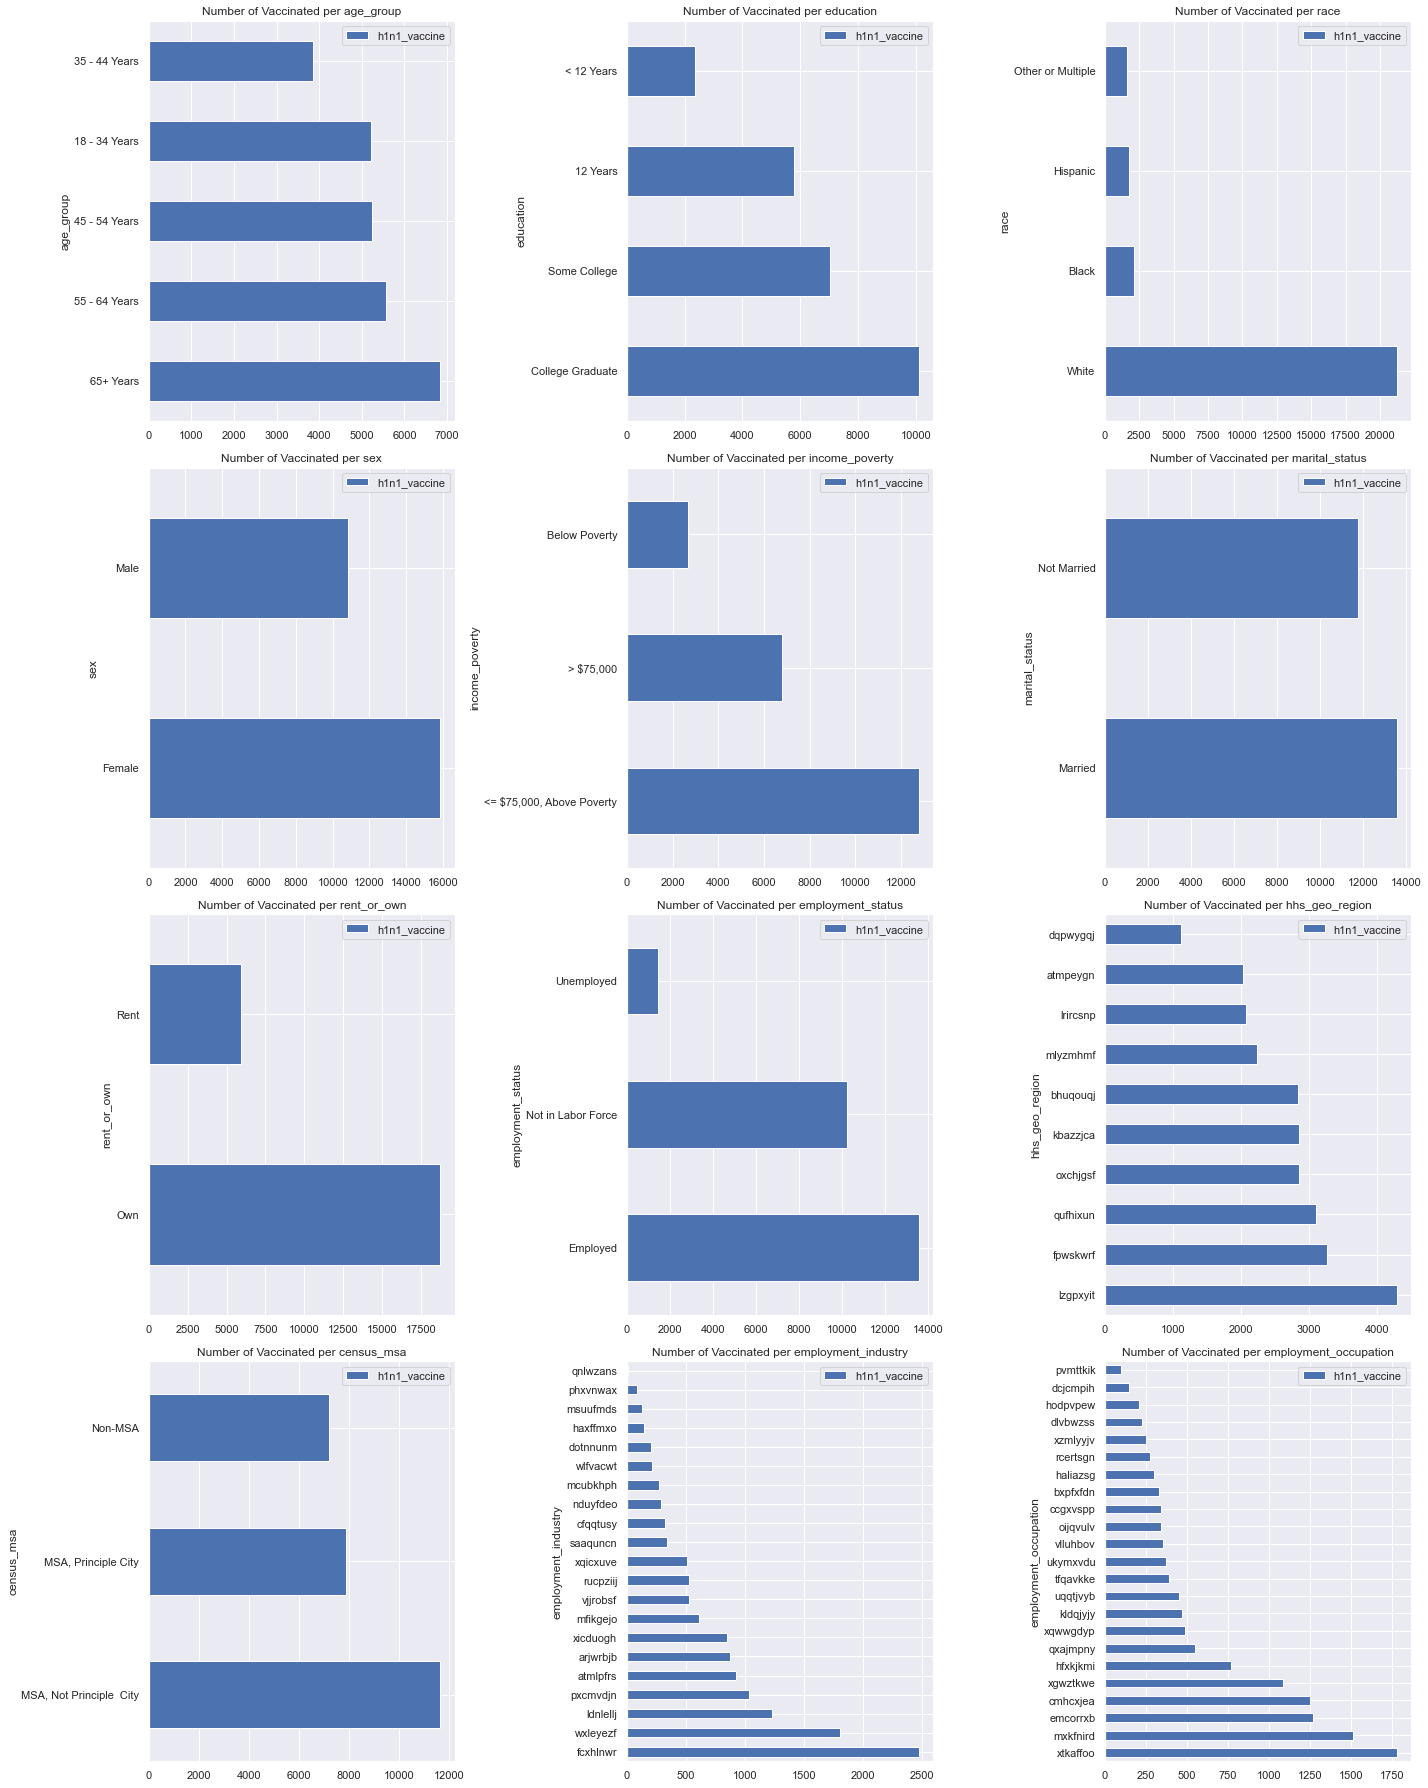

In [39]:
# general distribution
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 25))

columns = object_cols

for index, column in enumerate(columns):
    row = index // 3
    col = index % 3
    
    plot = features_labels.groupby(column)[['h1n1_vaccine']].count().sort_values(by='h1n1_vaccine', 
                                                                                  ascending=False).plot(kind='barh', 
                                                                                                        ax=axes[row, col])
    plot.set_title(f"Number of Vaccinated per {column}")
    #plot.set_xticklabels(plot.get_xticklabels(), rotation=30)

plt.tight_layout()
plt.show()

In [40]:
# can't quite get it in a loop, can come back to this later

In [41]:
# columns = object_cols
# n_cols = 6
# n_rows = 6

# fig, axes = plt.subplots(nrows=n_rows, ncols=1, figsize=(8, 8))

# for i, column in enumerate(columns):
#     bar_width = 0.35

#     index = range(len(features_labels))
#     x_not_vaccinated = [i - bar_width/2 for i in index]
#     x_vaccinated = [i + bar_width/2 for i in index]

#     ax = axes[i]

#     ax.bar(x=x_not_vaccinated, height=features_labels['h1n1_vaccine'].values,
#            label='Not Vaccinated', width=bar_width, color='blue')

#     ax.bar(x=x_vaccinated, height=features_labels['h1n1_vaccine'].values,
#            label='Vaccinated', width=bar_width, color='magenta')

#     ax.set_xlabel(column)
#     ax.set_ylabel('Count')
#     ax.set_title(f'Counts of h1n1_vaccine by {column}')
#     ax.set_xticks(index)
#     ax.set_xticklabels(features_labels[column].values, rotation=45)
#     ax.legend()

# # Adjust layout
# plt.tight_layout()
# plt.show()

Lot's of interesting things here. 
1. College grads have the highest vaccination count. Not surprising. 
2. Race has a huge imbalance - white people have the highest vaccination count. Not surprising. 
3. More females than males are vaccinated. Interesting but not super shocked.  
4. Those with a higher income had higher vaccination counts. Not surprising. 
5. Married people have higher vaccination counts than non-married. Not surprising - want to keep your family safe.
6. More home owners are vaccinated than renters. Interesting! Not shocked but expected maybe more of an even spread. 
7. More employed people are vaccinated than unemployed or not in labor force. Not surprising as if you are in person, a lot of employers make vaccinations mandatory. I'm assuming not in labor force means retired. A good number of retired people are vaccinated, which makes sense as we already saw the age group 65+ had the highest vaccination rate. 
8. Some columns (such as hhs_geo_region, employment_industry, and employment_occupation) are nonsensical. According to the data dictionary, these columns are represented as short, random strings. When we build our model, I wonder what ridge/lasso regression will tell us about these columns). 

Let's do some chi-square tests to see if anything is significantly related. 

In [42]:
# null = no significant relationship between vaccine and age_group
# alt = significnat relationship between vaccine and age_group
age_contingency_table=pd.crosstab(index=features_labels['h1n1_vaccine'],columns=features_labels['age_group'])
age_contingency_table

age_group,18 - 34 Years,35 - 44 Years,45 - 54 Years,55 - 64 Years,65+ Years
h1n1_vaccine,,,,,
0,4224,3087,4218,4212,5292
1,991,761,1020,1351,1551


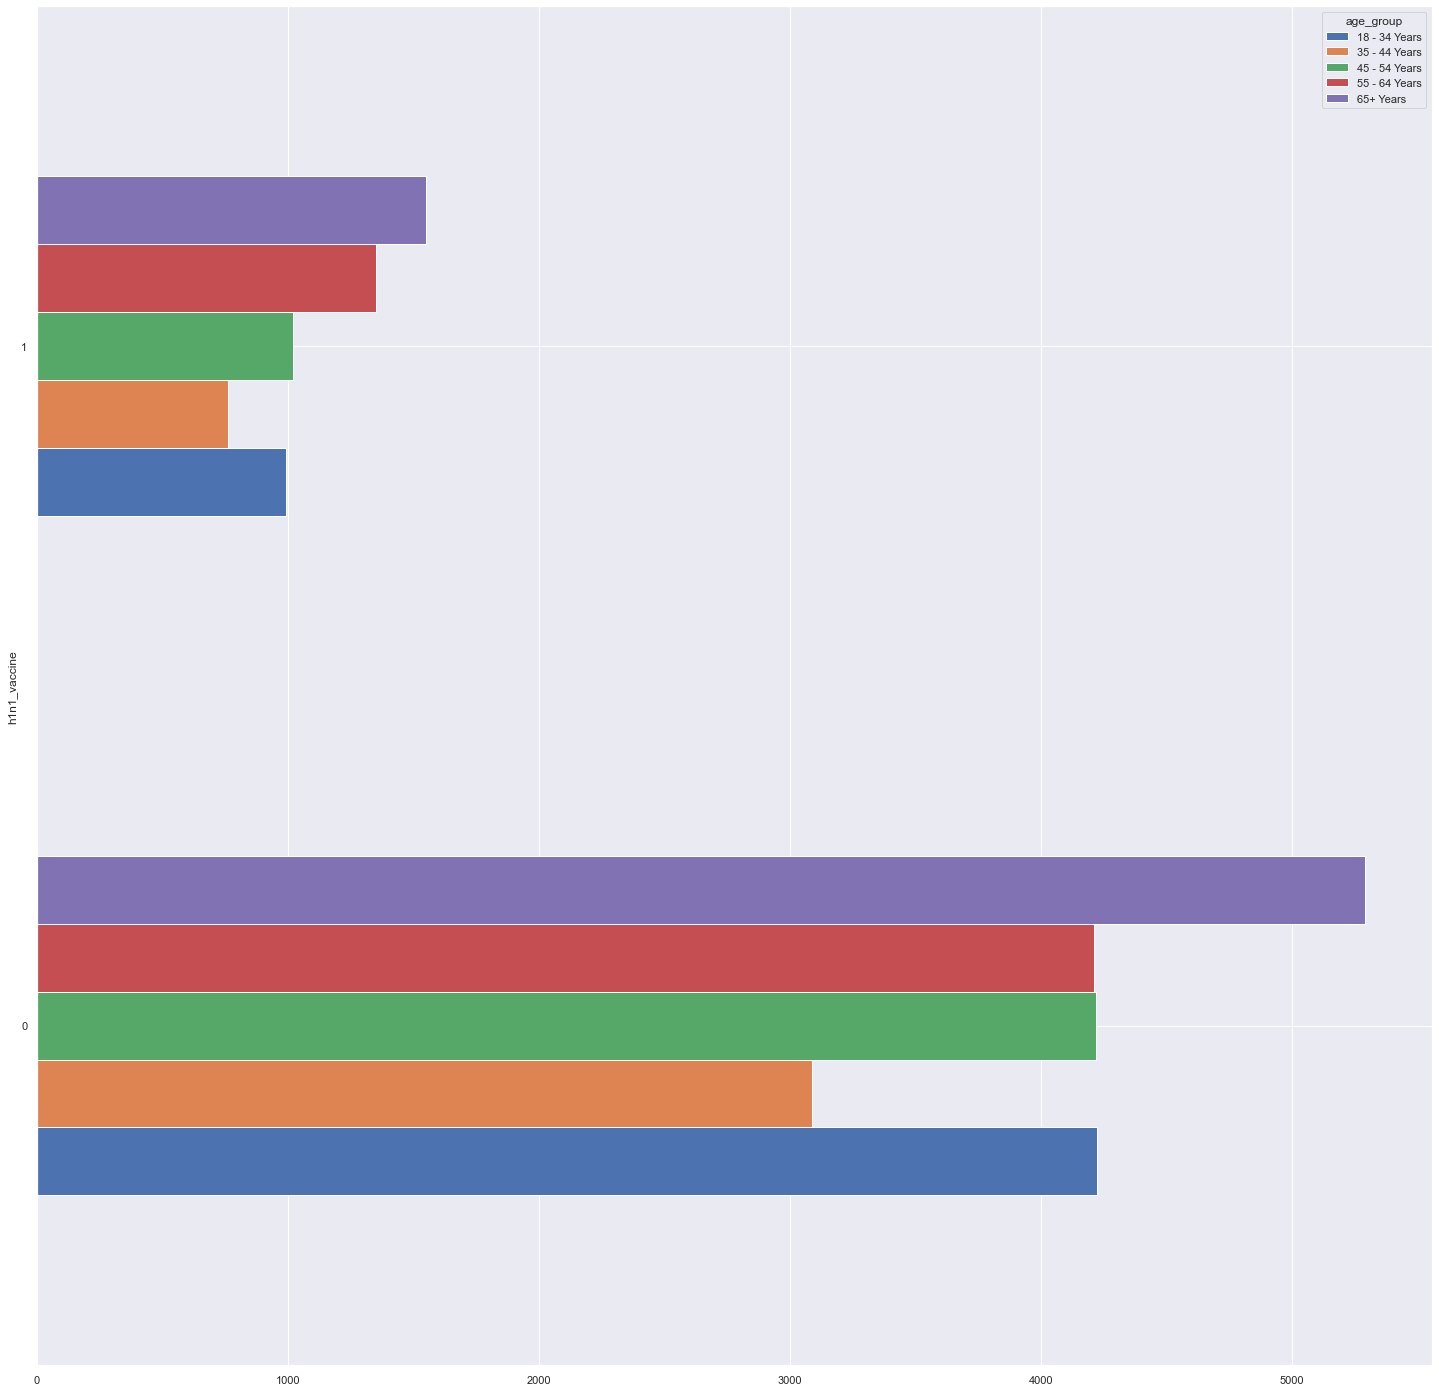

In [43]:
age_contingency_table.plot(kind='barh');

Most people in general are not vaccinated. 65+ has the highest count in both unvaccinated and vaccinated groups. 35-44 has the lowest count in both unvaccinated and vaccinated groups. 

In [44]:
# column_list = object_cols
# for column in column_list:
#     pd.crosstab(features_labels[column], features_labels['h1n1_vaccine']).plot(kind='barh')
#     plt.ylabel('Number of People')

In [45]:
education_contingency_table=pd.crosstab(index=features_labels['h1n1_vaccine'],columns=features_labels['education'])
education_contingency_table

education,12 Years,< 12 Years,College Graduate,Some College
h1n1_vaccine,,,,
0,4726,1968,7614,5579
1,1071,395,2483,1464


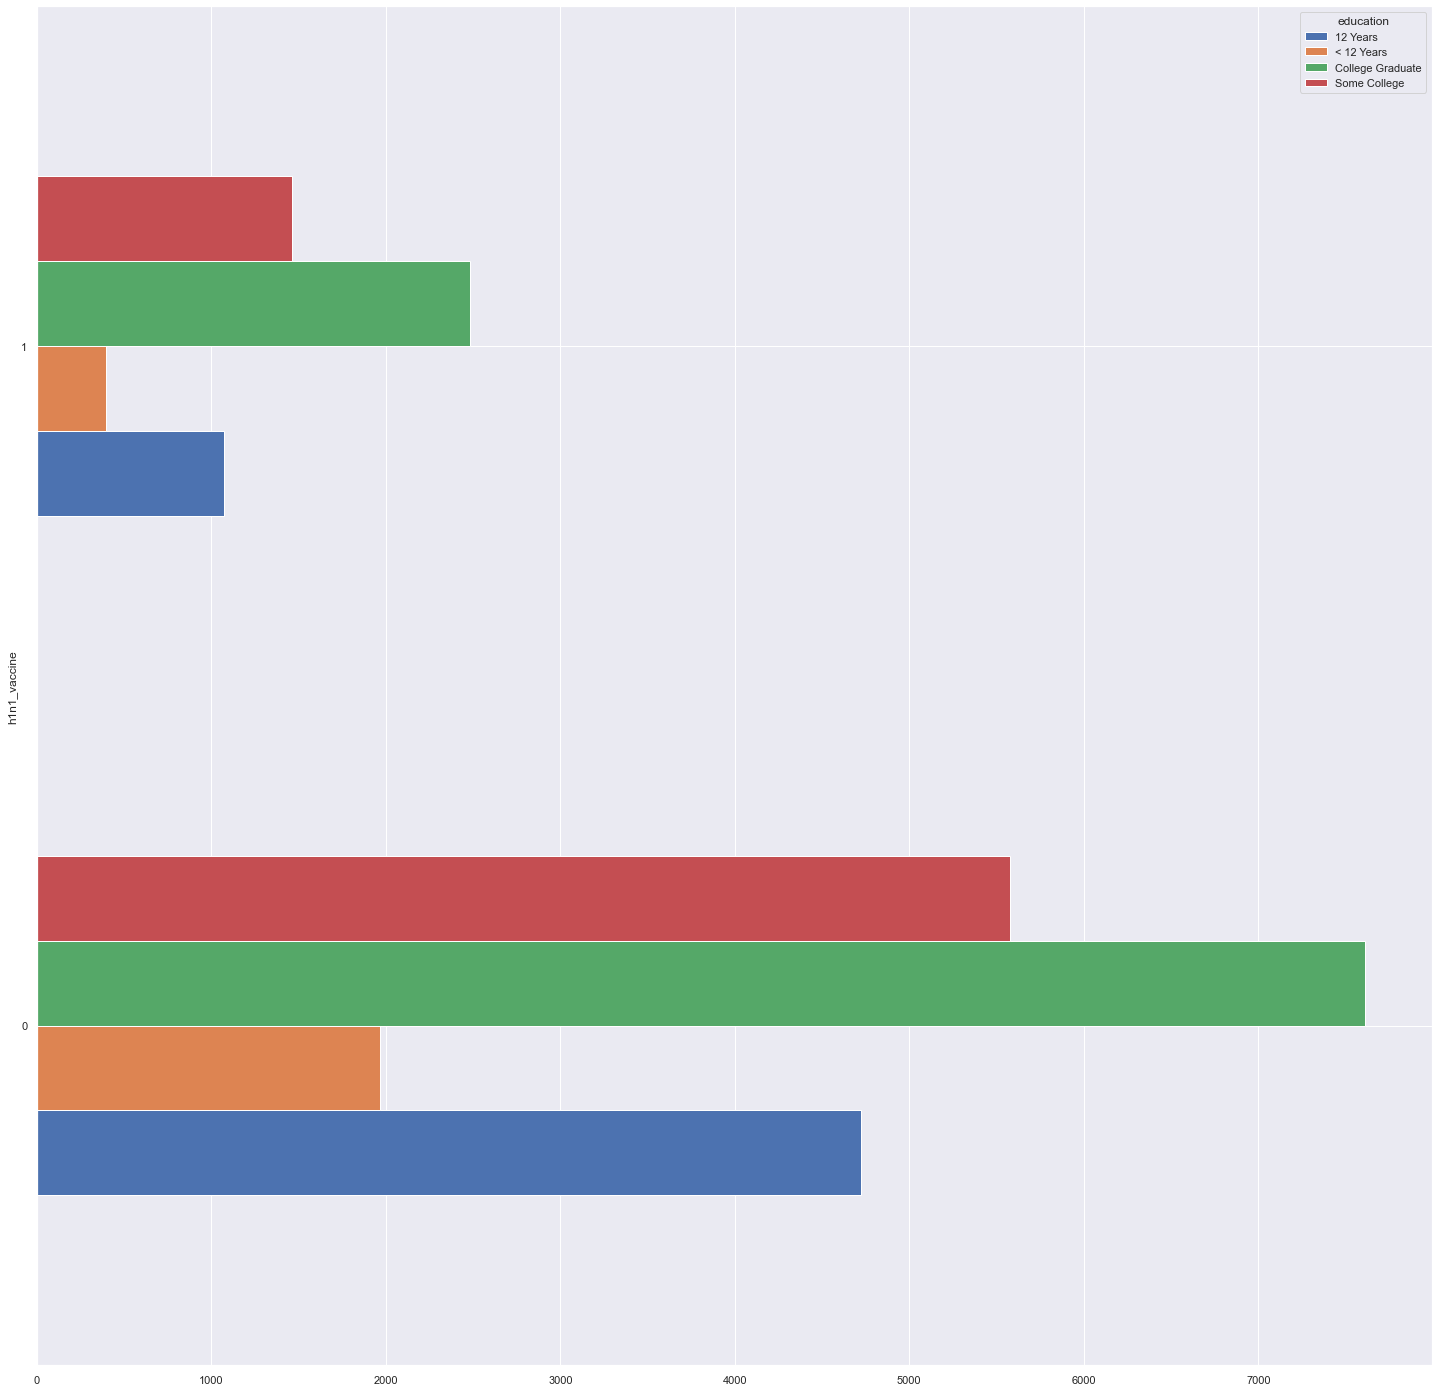

In [46]:
education_contingency_table.plot(kind='barh');

College grads have the highest counts in both vaccinated and unvaccinated, with those with under 12 years of education have the smallest counts. Pattern is consistent between vaccinated and unvaccinated. 

In [47]:
race_contingency_table=pd.crosstab(index=features_labels['h1n1_vaccine'],columns=features_labels['race'])
race_contingency_table

race,Black,Hispanic,Other or Multiple,White
h1n1_vaccine,,,,
0,1803,1390,1263,16577
1,315,365,349,4645


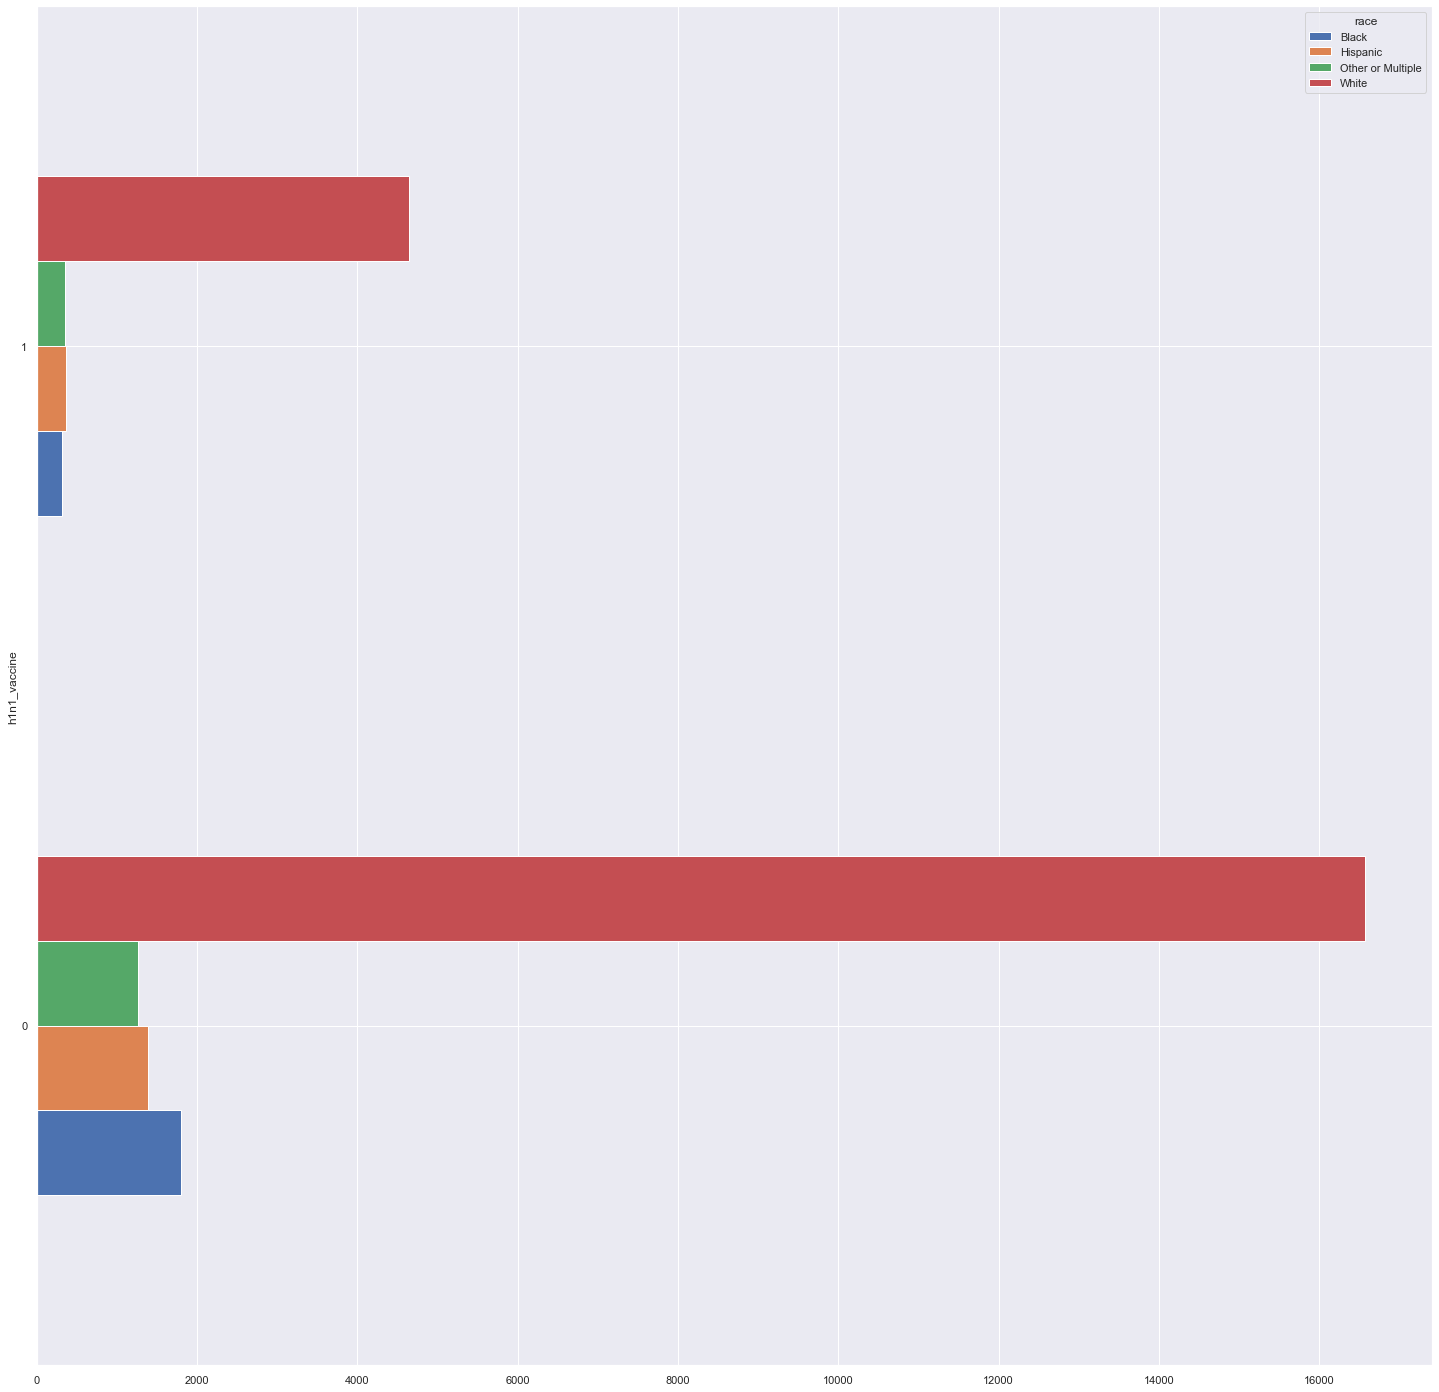

In [48]:
race_contingency_table.plot(kind='barh');

This is kind of staggering. White people have both the highest count in vaccinated and unvaccinated, but every other race has a fraction of it. 

In [49]:
sex_contingency_table=pd.crosstab(index=features_labels['h1n1_vaccine'],columns=features_labels['sex'])
sex_contingency_table

sex,Female,Male
h1n1_vaccine,,
0,12378,8655
1,3480,2194


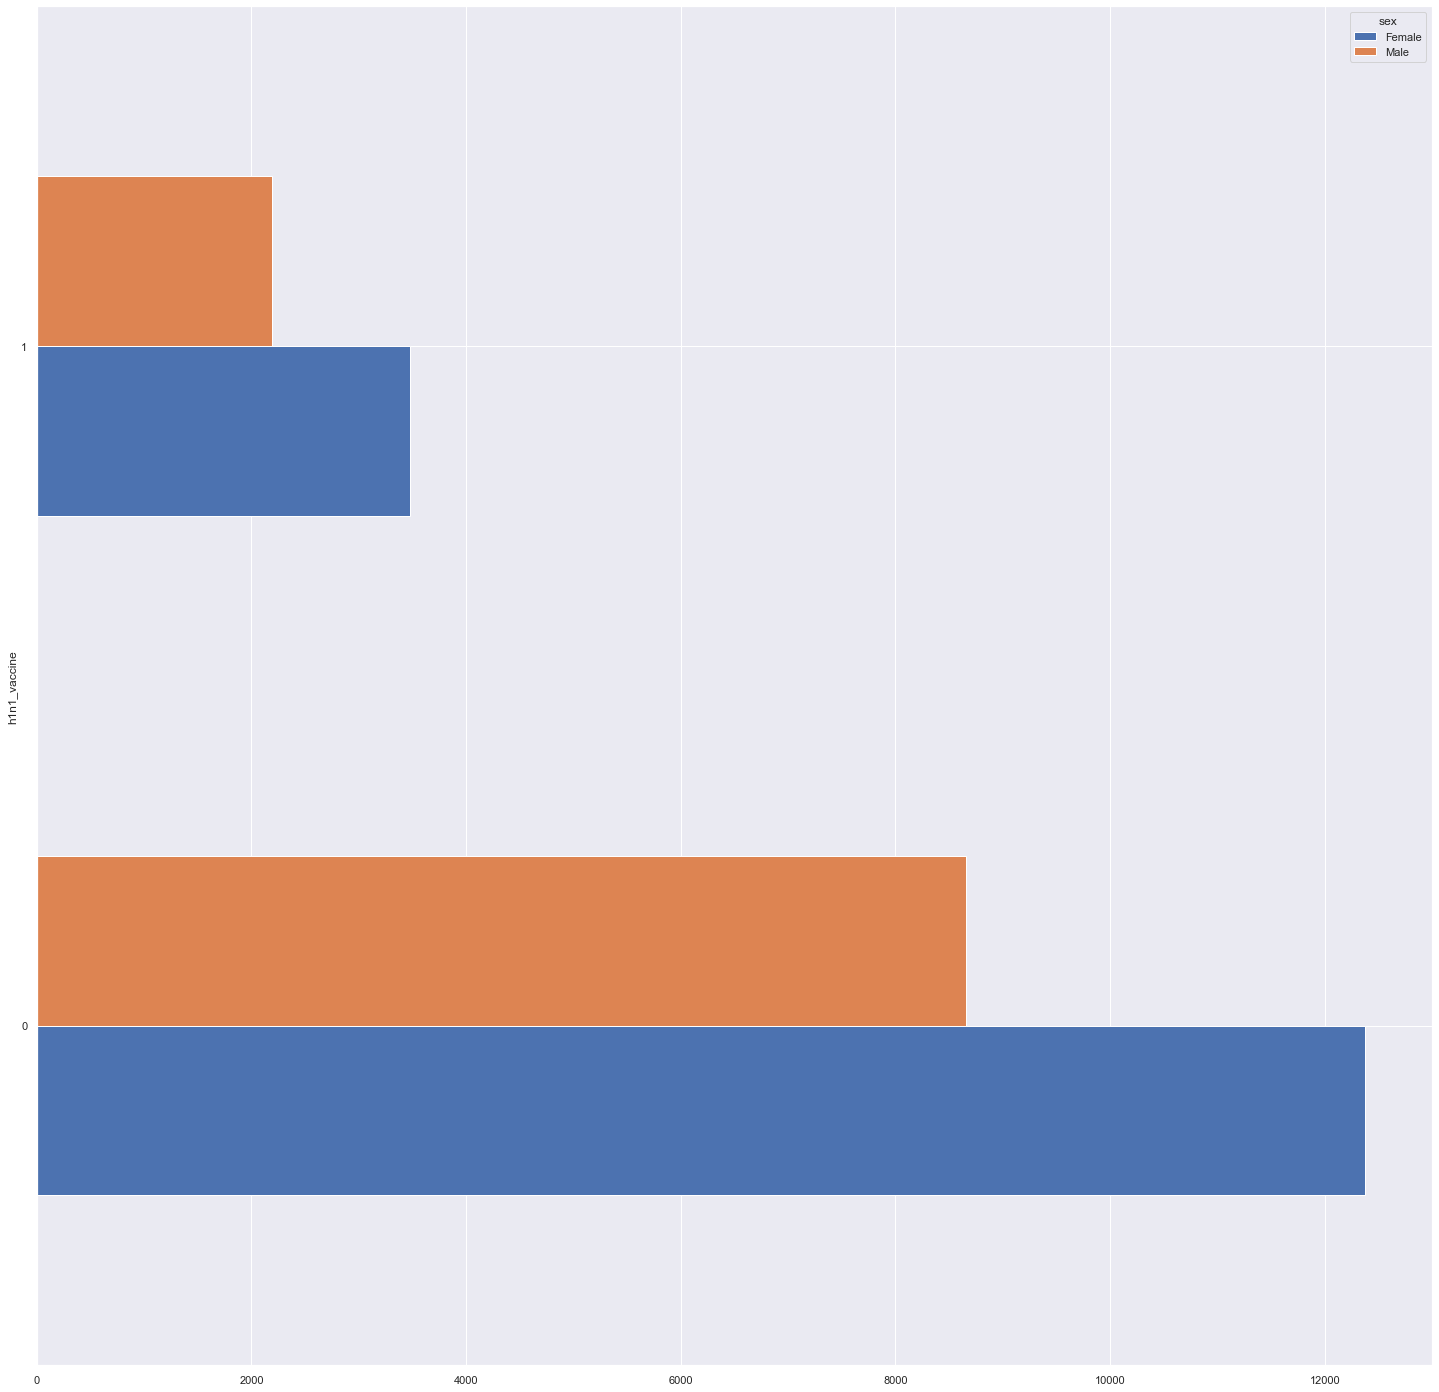

In [50]:
sex_contingency_table.plot(kind='barh');

In [51]:
features_labels['sex'].value_counts()

Female    15858
Male      10849
Name: sex, dtype: int64

More females than males are both vaccinated and unvaccinated. Makes sense as there are more females in the dataset.